- 1. Data Loading 
- 2. EDA 
- 3. Preprocessing 
- 4. Feature Engineering
- 5. Training

__Transaction Table__ <br>
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)<br>
* TransactionAMT: transaction payment amount in USD<br>
* ProductCD __(Categorical)__: product code, the product for each transaction<br>
* card1 - card6 __(Categorical)__: payment card information, such as card type, card category, issue bank, country, etc.<br>
* addr __(Categorical)__: address<br>
* dist: distance<br>
* P_ and (R__) emaildomain __(Categorical)__: purchaser and recipient email domain<br>
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.<br>
* D1-D15: timedelta, such as days between previous transaction, etc.<br>
* M1-M9 __(Categorical)__: match, such as names on card and address, etc.<br>
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.<br>

__Identity Table__<br>
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. <br>
Categorical Features:
* DeviceType
* DeviceInfo
* id12 - id38

# 1. Data Loading & Memory Reduce

In [1]:
!pip install --upgrade pip

     |████████████████████████████████| 1.4MB 3.3MB/s eta 0:00:01
  Found existing installation: pip 19.1.1
    Uninstalling pip-19.1.1:
      Successfully uninstalled pip-19.1.1


In [2]:
!pip3 install lightgbm

     |████████████████████████████████| 1.2MB 3.3MB/s eta 0:00:01


In [1]:
#### basic
import pandas as pd
import numpy as np

#### Visulization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#### ML
import sklearn
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
# import xgboost as xgb

#### Others
import datetime
import os, warnings, random
warnings.filterwarnings('ignore')

/Users/zhuyuwei/Library/Python/3.7/lib/python/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load data

In [120]:
transaction_train = pd.read_csv('./datasets/train_transaction.csv',index_col='TransactionID')
transaction_test = pd.read_csv('./datasets/test_transaction.csv',index_col='TransactionID')
identity_train = pd.read_csv('./datasets/train_identity.csv',index_col='TransactionID')
identity_test = pd.read_csv('./datasets/test_identity.csv',index_col='TransactionID')

KeyboardInterrupt: 

In [4]:
print('training set # for transaction: ' + str(len(transaction_train)))
transaction_train.head()

training set # for transaction: 590540


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print('test set # for transaction: ' + str(len(transaction_test)))
transaction_test.head()

test set # for transaction: 506691


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print('training set # for identity: ' + str(len(identity_train)))
identity_train.head(3)

training set # for identity: 144233


,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


Then, merge identity table to the transcation table to enrich features 

In [141]:
train = pd.merge(transaction_train, identity_train, on='TransactionID', how='left',indicator = True)
test = pd.merge(transaction_test, identity_test, on='TransactionID', how='left',indicator = True)

In [17]:
train['_merge'].value_counts()

left_only     446307
both          144233
right_only         0
Name: _merge, dtype: int64

Not all transactions can be found corresponding indentity

In [18]:
print(len(train))
train.head()

590540


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,both


## Memory Reduction

In [19]:
#helper functions

## Seeder
# :seed to make all processes deterministic 
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

## Memory Reducer                                     
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [20]:
SEED = 42
seed_everything(SEED)

In [21]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 648.79 Mb (66.8% reduction)
Mem. usage decreased to 563.92 Mb (66.3% reduction)


In [142]:
#################################################################################
# Converting Strings to ints(or floats if nan in column) using frequency encoding
# We will be able to use these columns as category or as numerical feature
cat_cols = ['DeviceType', 'DeviceInfo', 'ProductCD', 
            'card1', 'card2', 'card3',  'card4','card5', 'card6','addr1', 'addr2']

for col in cat_cols:
    print('Encoding', col)
    temp_df = pd.concat([train[[col]], test[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train[col] = train[col].map(col_encoded)
    test[col]  = test[col].map(col_encoded)
    print(col_encoded)

Encoding DeviceType
{'desktop': 159568, 'mobile': 118173}
Encoding DeviceInfo
{'Windows': 92710, 'iOS Device': 38502, 'MacOS': 23722, 'Trident/7.0': 12330, 'rv:11.0': 2650, 'SM-G532M Build/MMB29T': 980, 'rv:57.0': 968, 'SM-J700M Build/MMB29K': 829, 'SM-G610M Build/MMB29K': 804, 'SM-G531H Build/LMY48B': 682, 'rv:63.0': 474, 'ALE-L23 Build/HuaweiALE-L23': 458, 'SM-G935F Build/NRD90M': 450, 'SAMSUNG': 445, 'rv:61.0': 421, 'rv:52.0': 378, 'rv:59.0': 376, 'rv:62.0': 335, 'SM-G955U Build/NRD90M': 334, 'Moto G (4) Build/NPJ25.93-14.7': 326, 'SM-J730GM Build/NRD90M': 319, 'ANE-LX3': 315, 'rv:64.0': 310, 'SM-G950U Build/NRD90M': 308, 'LG-M700 Build/NMF26X': 300, 'SAMSUNG SM-G532M Build/MMB29T': 299, 'SM-G930V Build/NRD90M': 298, 'moto g(6) play': 295, 'LG-D693n Build/LRX22G': 283, 'rv:58.0': 280, 'SM-J320M Build/LMY47V': 275, 'Moto G (5) Plus': 272, 'Linux x86_64': 267, 'SM-J701M Build/NRD90M': 263, 'rv:60.0': 257, 'SM-A520F Build/NRD90M': 254, 'SM-G950U': 252, 'rv:48.0': 250, 'Moto G (5)': 244

{'W': 800657, 'C': 137785, 'R': 73346, 'H': 62397, 'S': 23046}
Encoding card1
{7919: 28015, 9500: 26243, 15885: 22691, 17188: 19606, 15066: 14606, 6019: 13268, 12695: 12732, 12544: 12694, 2803: 11043, 7585: 10097, 12839: 9593, 10616: 9419, 3154: 9253, 9633: 8909, 2884: 7683, 18132: 7635, 15497: 7266, 16132: 7253, 16075: 7053, 5812: 6697, 7508: 6659, 2616: 6196, 10112: 6058, 4461: 5959, 12501: 5886, 10057: 5642, 16659: 5627, 11207: 5595, 7664: 5237, 16136: 5155, 7826: 5021, 8320: 4946, 12577: 4942, 12932: 4906, 7861: 4640, 7207: 4611, 15063: 4582, 10486: 4573, 5033: 4557, 13832: 4546, 10023: 4449, 7815: 4387, 9112: 4288, 7676: 4077, 16560: 3914, 4806: 3842, 2772: 3654, 4436: 3622, 6530: 3604, 11839: 3561, 1675: 3528, 11201: 3492, 1444: 3369, 3821: 3362, 17399: 3319, 2455: 3291, 14290: 3260, 9803: 3139, 1974: 3086, 1724: 2985, 9026: 2970, 11157: 2957, 17055: 2946, 17131: 2945, 13249: 2935, 18018: 2786, 8528: 2686, 1893: 2683, 17400: 2668, 3682: 2617, 2392: 2604, 15651: 2545, 12686: 2525,

{321.0: 91731, 111.0: 82537, 555.0: 80404, 490.0: 70496, 583.0: 41503, 170.0: 33411, 545.0: 31894, 194.0: 31511, 514.0: 27225, 360.0: 26532, 174.0: 21406, 512.0: 19884, 408.0: 17160, 361.0: 14420, 215.0: 13801, 100.0: 13651, 399.0: 13458, 225.0: 13274, 553.0: 12202, 375.0: 12157, 476.0: 11690, 567.0: 11287, 268.0: 10651, 481.0: 10151, 543.0: 9968, 130.0: 8141, 298.0: 8069, 327.0: 7935, 500.0: 7475, 103.0: 6961, 204.0: 6731, 562.0: 6499, 206.0: 6342, 310.0: 6207, 161.0: 6176, 269.0: 5810, 404.0: 5593, 445.0: 5391, 494.0: 5373, 455.0: 5269, 390.0: 5097, 264.0: 4983, 250.0: 4887, 453.0: 4715, 122.0: 4451, 417.0: 4216, 369.0: 3626, 532.0: 3610, 142.0: 3609, 393.0: 3528, 181.0: 3513, 418.0: 3433, 452.0: 3014, 558.0: 2669, 177.0: 2618, 296.0: 2516, 127.0: 2323, 158.0: 2319, 470.0: 2149, 548.0: 2059, 513.0: 2048, 302.0: 2035, 517.0: 2028, 383.0: 2024, 346.0: 1898, 276.0: 1801, 554.0: 1796, 396.0: 1791, 216.0: 1758, 428.0: 1746, 579.0: 1739, 343.0: 1731, 420.0: 1627, 254.0: 1575, 247.0: 1518, 

{'debit': 824959, 'credit': 267648, 'debit or credit': 30, 'charge card': 16}
Encoding addr1
{299.0: 85045, 204.0: 77069, 325.0: 76902, 264.0: 72580, 330.0: 48387, 315.0: 43035, 441.0: 38890, 272.0: 35929, 123.0: 28700, 126.0: 28198, 337.0: 28081, 191.0: 27910, 184.0: 27205, 181.0: 25410, 143.0: 18431, 476.0: 17455, 310.0: 16127, 327.0: 15904, 387.0: 15737, 472.0: 15704, 512.0: 15251, 433.0: 14542, 231.0: 13532, 485.0: 12540, 269.0: 12156, 205.0: 11025, 225.0: 9886, 220.0: 9371, 251.0: 9146, 226.0: 8853, 494.0: 8726, 177.0: 8628, 498.0: 8539, 203.0: 7284, 420.0: 7107, 110.0: 6212, 436.0: 5882, 469.0: 5745, 170.0: 3810, 444.0: 3699, 324.0: 3692, 343.0: 3207, 384.0: 3063, 194.0: 3060, 122.0: 2898, 428.0: 2843, 158.0: 2633, 308.0: 2206, 284.0: 1911, 253.0: 1876, 492.0: 1824, 448.0: 1784, 502.0: 1565, 465.0: 1189, 296.0: 789, 130.0: 736, 536.0: 595, 161.0: 453, 157.0: 342, 511.0: 297, 348.0: 206, 356.0: 177, 418.0: 161, 375.0: 146, 483.0: 142, 431.0: 138, 148.0: 132, 216.0: 122, 242.0: 117

In [143]:
#################################################################################
# Converting Strings to ints(or floats if nan in column) using frequency encoding
# for id information in indentity table
# encoding seperately

id_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 
            'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

for col in id_cols:
    print('Encoding', col)
    print('training set:')
    col_encoded = train[col].value_counts().to_dict()
    print(col_encoded)
    train[col] = train[col].map(col_encoded)
    
    print('test set:')
    col_encoded = test[col].value_counts().to_dict()
    test[col]  = test[col].map(col_encoded)
    print(col_encoded)

Encoding id_12
training set:
{'NotFound': 123025, 'Found': 21208}
test set:
{'NotFound': 120895, 'Found': 21012}
Encoding id_13
training set:
{52.0: 58099, 49.0: 26365, 64.0: 14429, 33.0: 10048, 27.0: 3666, 20.0: 2878, 14.0: 2499, 63.0: 1468, 19.0: 1147, 25.0: 1066, 43.0: 842, 62.0: 813, 18.0: 688, 41.0: 654, 55.0: 523, 11.0: 373, 15.0: 372, 24.0: 318, 35.0: 317, 51.0: 196, 61.0: 108, 44.0: 85, 54.0: 67, 28.0: 59, 39.0: 34, 31.0: 29, 45.0: 26, 38.0: 22, 13.0: 21, 58.0: 17, 36.0: 15, 48.0: 10, 32.0: 10, 56.0: 9, 30.0: 7, 22.0: 5, 53.0: 4, 17.0: 3, 21.0: 3, 57.0: 3, 46.0: 3, 47.0: 3, 60.0: 3, 12.0: 2, 26.0: 2, 59.0: 1, 50.0: 1, 10.0: 1, 23.0: 1, 37.0: 1, 29.0: 1, 34.0: 1, 40.0: 1, 42.0: 1}
test set:
{27.0: 69616, 52.0: 51661, 14.0: 3928, 62.0: 939, 20.0: 926, 63.0: 582, 18.0: 530, 11.0: 517, 41.0: 432, 55.0: 258, 25.0: 236, 24.0: 213, 51.0: 153, 15.0: 148, 43.0: 65, 28.0: 18, 39.0: 11, 36.0: 10, 56.0: 10, 31.0: 9, 42.0: 8, 21.0: 5, 16.0: 3, 44.0: 2, 30.0: 2, 37.0: 2, 48.0: 2}
Encoding id

test set:
{266.0: 19692, 410.0: 11096, 427.0: 7838, 529.0: 7771, 153.0: 5134, 417.0: 4925, 271.0: 4914, 100.0: 4736, 542.0: 4668, 286.0: 4656, 215.0: 4405, 176.0: 3941, 352.0: 3867, 290.0: 3654, 567.0: 3437, 193.0: 3239, 548.0: 2335, 317.0: 2112, 621.0: 1876, 321.0: 1785, 390.0: 1706, 492.0: 1472, 633.0: 1367, 384.0: 1258, 341.0: 1251, 216.0: 1178, 122.0: 985, 312.0: 853, 454.0: 853, 484.0: 781, 607.0: 713, 574.0: 590, 399.0: 536, 144.0: 520, 277.0: 519, 214.0: 382, 630.0: 376, 139.0: 343, 337.0: 327, 307.0: 323, 181.0: 312, 339.0: 301, 373.0: 300, 533.0: 298, 414.0: 290, 348.0: 266, 303.0: 249, 395.0: 215, 372.0: 214, 380.0: 199, 400.0: 197, 127.0: 190, 270.0: 184, 650.0: 183, 197.0: 180, 278.0: 167, 585.0: 160, 629.0: 154, 223.0: 149, 275.0: 143, 517.0: 142, 613.0: 133, 449.0: 132, 487.0: 126, 204.0: 118, 622.0: 117, 280.0: 113, 497.0: 113, 186.0: 108, 161.0: 107, 146.0: 106, 350.0: 105, 253.0: 102, 242.0: 97, 620.0: 97, 383.0: 94, 428.0: 93, 525.0: 91, 420.0: 91, 145.0: 84, 501.0: 8

test set:
{507.0: 11881, 222.0: 9778, 595.0: 8336, 563.0: 7569, 325.0: 7294, 533.0: 5872, 549.0: 5327, 214.0: 5281, 600.0: 4782, 333.0: 3288, 161.0: 3260, 127.0: 2620, 305.0: 2612, 500.0: 2560, 612.0: 2516, 597.0: 2299, 315.0: 2271, 489.0: 2266, 368.0: 2164, 497.0: 2087, 566.0: 2024, 391.0: 1690, 256.0: 1679, 535.0: 1585, 277.0: 1529, 177.0: 1380, 280.0: 1328, 122.0: 1307, 484.0: 1197, 561.0: 1173, 266.0: 1173, 225.0: 1109, 611.0: 1074, 469.0: 1019, 565.0: 1005, 472.0: 953, 521.0: 885, 417.0: 885, 638.0: 835, 146.0: 821, 278.0: 810, 107.0: 795, 299.0: 686, 144.0: 637, 411.0: 632, 401.0: 535, 100.0: 503, 216.0: 502, 394.0: 486, 178.0: 473, 186.0: 458, 340.0: 458, 181.0: 454, 139.0: 437, 588.0: 400, 360.0: 379, 153.0: 370, 541.0: 336, 253.0: 323, 404.0: 321, 610.0: 298, 272.0: 274, 324.0: 266, 424.0: 255, 514.0: 220, 223.0: 218, 142.0: 213, 501.0: 211, 439.0: 210, 215.0: 203, 575.0: 163, 254.0: 155, 633.0: 153, 111.0: 139, 269.0: 128, 314.0: 127, 204.0: 116, 160.0: 116, 320.0: 111, 193.0

test set:
{711.0: 1796, 252.0: 1010, 228.0: 230, 576.0: 66, 849.0: 66, 770.0: 61, 103.0: 53, 255.0: 53, 277.0: 53, 755.0: 50, 409.0: 44, 470.0: 42, 537.0: 41, 757.0: 38, 249.0: 35, 848.0: 35, 286.0: 28, 262.0: 28, 453.0: 26, 480.0: 26, 629.0: 25, 734.0: 25, 226.0: 21, 142.0: 20, 220.0: 20, 440.0: 19, 619.0: 19, 251.0: 19, 272.0: 18, 819.0: 16, 585.0: 15, 668.0: 15, 433.0: 14, 693.0: 13, 515.0: 13, 166.0: 13, 353.0: 12, 368.0: 12, 609.0: 12, 836.0: 12, 420.0: 12, 360.0: 11, 596.0: 11, 500.0: 11, 795.0: 11, 820.0: 11, 327.0: 10, 719.0: 10, 208.0: 10, 408.0: 9, 290.0: 9, 762.0: 9, 306.0: 9, 222.0: 9, 338.0: 9, 459.0: 9, 310.0: 9, 501.0: 8, 363.0: 8, 191.0: 8, 720.0: 8, 573.0: 8, 632.0: 8, 591.0: 8, 219.0: 8, 601.0: 7, 410.0: 7, 436.0: 7, 109.0: 7, 487.0: 7, 525.0: 7, 345.0: 7, 699.0: 7, 839.0: 6, 432.0: 6, 582.0: 6, 481.0: 6, 796.0: 6, 801.0: 6, 183.0: 6, 835.0: 6, 101.0: 5, 854.0: 5, 491.0: 5, 462.0: 5, 386.0: 5, 202.0: 5, 802.0: 5, 138.0: 5, 761.0: 5, 383.0: 5, 347.0: 5, 852.0: 5, 100.0

test set:
{321.0: 2739, 205.0: 268, 426.0: 233, 442.0: 111, 432.0: 53, 509.0: 50, 371.0: 49, 501.0: 48, 123.0: 44, 472.0: 42, 236.0: 39, 524.0: 36, 479.0: 35, 385.0: 30, 463.0: 28, 143.0: 28, 264.0: 27, 250.0: 26, 239.0: 26, 516.0: 24, 391.0: 21, 481.0: 21, 247.0: 20, 270.0: 19, 314.0: 18, 486.0: 16, 383.0: 15, 184.0: 13, 126.0: 13, 431.0: 13, 511.0: 12, 355.0: 12, 330.0: 12, 320.0: 11, 360.0: 10, 356.0: 10, 538.0: 10, 170.0: 10, 415.0: 9, 260.0: 9, 122.0: 9, 110.0: 9, 359.0: 9, 454.0: 9, 339.0: 9, 177.0: 9, 422.0: 9, 519.0: 8, 522.0: 8, 430.0: 8, 302.0: 8, 181.0: 8, 537.0: 8, 277.0: 8, 404.0: 8, 199.0: 8, 337.0: 8, 408.0: 8, 381.0: 8, 258.0: 8, 148.0: 7, 379.0: 7, 452.0: 7, 167.0: 7, 438.0: 7, 226.0: 7, 134.0: 7, 518.0: 7, 299.0: 7, 300.0: 7, 231.0: 6, 417.0: 6, 216.0: 6, 159.0: 6, 105.0: 6, 485.0: 6, 390.0: 6, 155.0: 6, 218.0: 6, 455.0: 6, 498.0: 6, 466.0: 6, 341.0: 6, 296.0: 6, 265.0: 5, 523.0: 5, 168.0: 5, 489.0: 5, 315.0: 5, 532.0: 5, 304.0: 5, 484.0: 5, 115.0: 5, 443.0: 5, 492.0:

{'chrome 70.0': 16054, 'mobile safari 12.0': 13098, 'mobile safari 11.0': 10232, 'chrome 71.0': 9489, 'chrome 69.0': 8293, 'chrome 70.0 for android': 7624, 'chrome 68.0': 6449, 'chrome 67.0': 6122, 'chrome 69.0 for android': 6022, 'ie 11.0 for desktop': 5173, 'chrome 71.0 for android': 5029, 'edge 17.0': 4871, 'chrome 67.0 for android': 3636, 'safari 12.0': 3550, 'chrome 68.0 for android': 3520, 'safari 11.0': 2897, 'firefox 63.0': 1899, 'samsung browser 7.4': 1369, 'firefox 61.0': 1321, 'firefox 64.0': 1251, 'mobile safari 10.0': 1154, 'firefox 62.0': 1107, 'safari 10.0': 947, 'ie 11.0 for tablet': 683, 'chrome 70.0 for ios': 665, 'chrome 66.0 for android': 592, 'chrome 55.0 for android': 512, 'firefox 55.0': 508, 'samsung browser 7.2': 493, 'android webview 4.0': 484, 'chrome 71.0 for ios': 421, 'edge 16.0': 404, 'google search application 64.0': 382, 'firefox 60.0': 382, 'chrome 49.0': 362, 'mobile safari 9.0': 355, 'chrome 66.0': 344, 'chrome 65.0 for android': 323, 'chrome 68.0 fo

{'T': 77814, 'F': 63171}
test set:
{'T': 71650, 'F': 65327}
Encoding id_36
training set:
{'F': 134066, 'T': 6919}
test set:
{'F': 133287, 'T': 3690}
Encoding id_37
training set:
{'T': 110452, 'F': 30533}
test set:
{'T': 104697, 'F': 32280}
Encoding id_38
training set:
{'F': 73922, 'T': 67063}
test set:
{'F': 95058, 'T': 41919}


In [146]:
# M columns
#################################################################################
# Converting Strings to ints(or floats if nan in column)

for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    train[col] = train[col].map({'T':1, 'F':0})
    test[col]  = test[col].map({'T':1, 'F':0})

for col in ['M4']:
    print('Encoding', col)
    temp_df = pd.concat([train[[col]], test[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train[col] = train[col].map(col_encoded)
    test[col]  = test[col].map(col_encoded)
    print(col_encoded)

Encoding M4
{357789.0: 357789, 122947.0: 122947, 97306.0: 97306}


In [147]:
#final minification
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 601.48 Mb (0.4% reduction)


KeyboardInterrupt: 

In [148]:
#export
train.to_pickle('train_mini.pkl')
test.to_pickle('test_mini.pkl')

In [149]:
train = pd.read_pickle('train_mini.pkl')
test = pd.read_pickle('test_mini.pkl')

# 3. Feature Engineering

Several ideas:
- use PCA to reduce # of columns (for groups, e.g. card 1-6, id, etc.) https://www.kaggle.com/kabure/almost-complete-feature-engineering-ieee-data#V-Features
- aggregation https://www.kaggle.com/artgor/eda-and-models#Feature-engineering; https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again?scriptVersionId=18889353
- focus on important features https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
- frequency encoding https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again?scriptVersionId=18941048
- target mean? https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again?scriptVersionId=18941048

Others:
- M columns: all binary (except M4), can generate M_sum, M_na
- C columns: C columns are some counts, based on client identity. Most popular Value is "1". can generate C_sum, C_na, or check if C counts is valid or not
- split id: e.g. device info https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm-corrected
- transaction time: https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm-corrected


In [150]:
######################################################
#calculate transaction amount by group
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')

In [151]:
# New feature - log of transaction amount. ()
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

# New feature - decimal part of the transaction amount.
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - day of week in which a transaction happened.
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

In [152]:
#new feature (8.21)
#add more transaction amount groupby
train['TransactionAmt_to_mean_card2'] = train['TransactionAmt'] / train.groupby(['card2'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card2'] = train['TransactionAmt'] / train.groupby(['card2'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card2'] = test['TransactionAmt'] / test.groupby(['card2'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card2'] = test['TransactionAmt'] / test.groupby(['card2'])['TransactionAmt'].transform('std')


In [153]:
#new feature (8.21)
#add transaction amount groupby product type(productCD)
train['TransactionAmt_to_mean_product'] = train['TransactionAmt'] / train.groupby(['ProductCD'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_product'] = train['TransactionAmt'] / train.groupby(['ProductCD'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_product'] = test['TransactionAmt'] / test.groupby(['ProductCD'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_product'] = test['TransactionAmt'] / test.groupby(['ProductCD'])['TransactionAmt'].transform('std')

In [154]:
#new feature(8.21)
#interaction between product type and transaction time, location info(address, distance)
for feature in ['Transaction_day_of_week__ProductCD', 'Transaction_hour__ProductCD', 
                'addr1__ProductCD', 'addr2__ProductCD', 'dist1__ProductCD', 'dist2__ProductCD']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

In [155]:
#new feature(8.21)
# New feature: max & min transaction amount by groups
train['TransactionAmt_to_max_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('max')
train['TransactionAmt_to_max_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('max')
train['TransactionAmt_to_max_card2'] = train['TransactionAmt'] / train.groupby(['card2'])['TransactionAmt'].transform('max')
train['TransactionAmt_to_min_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('min')
train['TransactionAmt_to_min_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('min')
train['TransactionAmt_to_min_card2'] = train['TransactionAmt'] / train.groupby(['card2'])['TransactionAmt'].transform('min')

test['TransactionAmt_to_max_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('max')
test['TransactionAmt_to_max_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('max')
test['TransactionAmt_to_max_card2'] = test['TransactionAmt'] / test.groupby(['card2'])['TransactionAmt'].transform('max')
test['TransactionAmt_to_min_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('min')
test['TransactionAmt_to_min_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('min')
test['TransactionAmt_to_min_card2'] = test['TransactionAmt'] / test.groupby(['card2'])['TransactionAmt'].transform('min')

In [156]:
#new feature(8.21)
#https://www.kaggle.com/nroman/eda-for-cis-fraud-detection#New-feature:-number-of-NaN's
#https://www.kaggle.com/c/ieee-fraud-detection/discussion/105130#latest-604661
#number of NaNs 
#V1 ~ V11
#V12 ~ V34
#V12 ~ V34
#V35 ~ V52
#V53 ~ V74
#V75 ~ V94
#V95 ~ V137
#V138 ~ V166 (high null ratio)
#V167 ~ V216 (high null ratio)
#V217 ~ V278 (high null ratio, 2 different null ratios)
#V279 ~ V321 (2 different null ratios)
#V322 ~ V339 (high null ratio)
#haven't figure out how to use this finding
train['Total_nulls'] = train.isnull().sum(axis=1)
test['Total_nulls'] = test.isnull().sum(axis=1)

In [159]:
#new feature(8.21)
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499
# bin email address
# do not use frequency encoding for email before
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

for col in ['P_emaildomain', 'R_emaildomain']:
    print('Encoding', col)
    temp_df = pd.concat([train[[col]], test[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train[col] = train[col].map(col_encoded)
    test[col]  = test[col].map(col_encoded)
    print(col_encoded)

Encoding P_emaildomain
{'gmail.com': 435803, 'yahoo.com': 182784, 'hotmail.com': 85649, 'anonymous.com': 71062, 'aol.com': 52337, 'comcast.net': 14474, 'icloud.com': 12316, 'outlook.com': 9934, 'att.net': 7647, 'msn.com': 7480, 'sbcglobal.net': 5767, 'live.com': 5720, 'verizon.net': 5011, 'ymail.com': 4075, 'bellsouth.net': 3437, 'yahoo.com.mx': 2827, 'me.com': 2713, 'cox.net': 2657, 'optonline.net': 1937, 'live.com.mx': 1470, 'charter.net': 1443, 'mail.com': 1156, 'rocketmail.com': 1105, 'gmail': 993, 'earthlink.net': 979, 'outlook.es': 863, 'mac.com': 862, 'hotmail.fr': 674, 'hotmail.es': 627, 'frontier.com': 594, 'roadrunner.com': 583, 'juno.com': 574, 'windstream.net': 552, 'web.de': 518, 'aim.com': 468, 'embarqmail.com': 464, 'twc.com': 439, 'frontiernet.net': 397, 'netzero.com': 387, 'centurylink.net': 386, 'q.com': 362, 'yahoo.fr': 344, 'hotmail.co.uk': 334, 'suddenlink.net': 323, 'netzero.net': 319, 'cfl.rr.com': 318, 'cableone.net': 311, 'prodigy.net.mx': 303, 'gmx.de': 298, '

# 4. Preprocessing
## Drop columns with too many NaN

In [21]:
for column in train:
    total = len(train)
    print('{0} : {1}'.format(column, train[column].isnull().sum()/total))

isFraud : 0.0
TransactionDT : 0.0
TransactionAmt : 0.0
ProductCD : 0.0
card1 : 0.0
card2 : 0.015126833068039422
card3 : 0.0026501168422122124
card4 : 0.00267043722694483
card5 : 0.007212043214684865
card6 : 0.0026602770345785214
addr1 : 0.1112642666034477
addr2 : 0.1112642666034477
dist1 : 0.596523520845328
dist2 : 0.9362837403054831
P_emaildomain : 0.1599485216920107
R_emaildomain : 0.7675161716395164
C1 : 0.0
C2 : 0.0
C3 : 0.0
C4 : 0.0
C5 : 0.0
C6 : 0.0
C7 : 0.0
C8 : 0.0
C9 : 0.0
C10 : 0.0
C11 : 0.0
C12 : 0.0
C13 : 0.0
C14 : 0.0
D1 : 0.0021488806854743116
D2 : 0.4754919226470688
D3 : 0.44514850814508755
D4 : 0.2860466691502693
D5 : 0.524674027161581
D6 : 0.8760676668811597
D7 : 0.9340992989467267
D8 : 0.8731229044603245
D9 : 0.8731229044603245
D10 : 0.1287330240119213
D11 : 0.47293494090154775
D12 : 0.8904104717715988
D13 : 0.8950926270870728
D14 : 0.8946946862193924
D15 : 0.1509008703898127
M1 : 0.4590713584177194
M2 : 0.4590713584177194
M3 : 0.4590713584177194
M4 : 0.47658753005723

V282 : 0.0021488806854743116
V283 : 0.0021488806854743116
V284 : 2.0320384732617603e-05
V285 : 2.0320384732617603e-05
V286 : 2.0320384732617603e-05
V287 : 2.0320384732617603e-05
V288 : 0.0021488806854743116
V289 : 0.0021488806854743116
V290 : 2.0320384732617603e-05
V291 : 2.0320384732617603e-05
V292 : 2.0320384732617603e-05
V293 : 2.0320384732617603e-05
V294 : 2.0320384732617603e-05
V295 : 2.0320384732617603e-05
V296 : 0.0021488806854743116
V297 : 2.0320384732617603e-05
V298 : 2.0320384732617603e-05
V299 : 2.0320384732617603e-05
V300 : 0.0021488806854743116
V301 : 0.0021488806854743116
V302 : 2.0320384732617603e-05
V303 : 2.0320384732617603e-05
V304 : 2.0320384732617603e-05
V305 : 2.0320384732617603e-05
V306 : 2.0320384732617603e-05
V307 : 2.0320384732617603e-05
V308 : 2.0320384732617603e-05
V309 : 2.0320384732617603e-05
V310 : 2.0320384732617603e-05
V311 : 2.0320384732617603e-05
V312 : 2.0320384732617603e-05
V313 : 0.0021488806854743116
V314 : 0.0021488806854743116
V315 : 0.0021488806

In [61]:
def drop_sparse_column(threshold, df_train, df_test):
    new_train = df_train.copy()
    new_test = df_test.copy()
    total = len(df_train)
    for column in df_train:
        percent = df_train[column].isnull().sum()/total
        if percent > threshold:
            new_train = new_train.drop(columns = [column])
            new_test = new_test.drop(columns = [column])
    return new_train, new_test

In [62]:
train, test = drop_sparse_column(0.9, train,test)

In [160]:
train.head(3)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,TransactionAmt_to_max_card4,TransactionAmt_to_max_card2,TransactionAmt_to_min_card1,TransactionAmt_to_min_card4,TransactionAmt_to_min_card2,Total_nulls,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,800657,56,NaN,956845.0,9524.0,309.0,267648.0,...,0.014221,NaN,22.281250,13.703125,NaN,247,NaN,nan,NaN,nan
2987001,0,86401,29.0,800657,1338,5593.0,956845.0,347386.0,49491.0,267648.0,...,0.000908,0.004768,2.900391,106.625000,5.800781,236,google,com,NaN,nan
2987002,0,86469,59.0,800657,1794,70496.0,956845.0,719649.0,102930.0,824959.0,...,0.009148,0.009148,4.718750,235.125000,139.125000,223,microsoft,com,NaN,nan


## Drop single value dominant columns

In [64]:
def drop_single_dominant(threshold, df_train, df_test):
    new_train = df_train.copy()
    isfraud = new_train['isFraud']
    new_train = new_train.drop(columns = ['isFraud'])
    new_test = df_test.copy()
    for column in new_train:
        if train[column].value_counts(dropna = False, normalize = True).values[0] > threshold:
            new_train = new_train.drop(columns = [column])
            new_test = new_test.drop(columns = [column])
    new_train['isFraud'] = isfraud
    return new_train, new_test

In [66]:
train, test = drop_single_dominant(0.9, train, test)

In [67]:
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,P_emaildomain__C2,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,isFraud
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,800657,56,NaN,956845.0,9524.0,309.0,267648.0,43035.0,...,259908,42,3125,6342,29922,2282,12205,706,13895,0
2987001,86401,29.0,800657,1338,5593.0,956845.0,347386.0,49491.0,267648.0,76902.0,...,259908,1096,3101,1944,20050,358,9216,1105,17319,0
2987002,86469,59.0,800657,1794,70496.0,956845.0,719649.0,102930.0,824959.0,48387.0,...,259908,248,3124,6059,23252,720,10554,69,14306,0
2987003,86499,50.0,800657,7635,11287.0,956845.0,347386.0,47061.0,824959.0,17455.0,...,259908,1096,3080,1086,1551,2659,527,996,5442,0
2987004,86506,50.0,62397,30,27225.0,956845.0,347386.0,49491.0,267648.0,7107.0,...,221143,1085,2873,1944,12105,1487,5234,1105,16080,0


## Drop one value columns

In [68]:
def drop_one_value(df_train, df_test):
    new_train = df_train.copy()
    new_test = df_test.copy()
    for column in new_train:
        if train[column].nunique() <= 1:
            new_train = new_train.drop(columns = [column])
            new_test = new_test.drop(columns = [column])
    return new_train, new_test

In [69]:
train, test = drop_one_value(train, test)

In [70]:
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,P_emaildomain__C2,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,isFraud
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,800657,56,NaN,956845.0,9524.0,309.0,267648.0,43035.0,...,259908,42,3125,6342,29922,2282,12205,706,13895,0
2987001,86401,29.0,800657,1338,5593.0,956845.0,347386.0,49491.0,267648.0,76902.0,...,259908,1096,3101,1944,20050,358,9216,1105,17319,0
2987002,86469,59.0,800657,1794,70496.0,956845.0,719649.0,102930.0,824959.0,48387.0,...,259908,248,3124,6059,23252,720,10554,69,14306,0
2987003,86499,50.0,800657,7635,11287.0,956845.0,347386.0,47061.0,824959.0,17455.0,...,259908,1096,3080,1086,1551,2659,527,996,5442,0
2987004,86506,50.0,62397,30,27225.0,956845.0,347386.0,49491.0,267648.0,7107.0,...,221143,1085,2873,1944,12105,1487,5234,1105,16080,0


## Drop high correlated columns
### Not run this part

In [32]:
# def drop_high_correlation(threshold, df_train, df_test):
#     new_train = df_train.copy()
#     new_test = df_test.copy()
#     # Create correlation matrix
#     corr_matrix = new_train.corr().abs()
#     # Select upper triangle of correlation matrix
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#     # Find index of feature columns with correlation greater than 0.95
#     to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
#     new_train = new_train.drop(new_train[to_drop],axis = 1)
#     new_test = new_test.drop(new_test[to_drop],axis = 1)
#     return new_train,new_test

#this function might can be replaced by ks_2samp
########################### Features elimination 
'''
from scipy.stats import ks_2samp
features_check = []
columns_to_check = set(list(train_df)).difference(base_columns)
for i in columns_to_check:
    features_check.append(ks_2samp(test_df[i], train_df[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)
'''

'\nfrom scipy.stats import ks_2samp\nfeatures_check = []\ncolumns_to_check = set(list(train_df)).difference(base_columns)\nfor i in columns_to_check:\n    features_check.append(ks_2samp(test_df[i], train_df[i])[1])\n\nfeatures_check = pd.Series(features_check, index=columns_to_check).sort_values() \nfeatures_discard = list(features_check[features_check==0].index)\nprint(features_discard)\n'

In [33]:
# new_train, new_test = drop_high_correlation(0.95, new_train, new_test)

In [34]:
# new_train.head()

## Useful features
### Not run this cell

In [35]:
# useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
#                    'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
#                    'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
#                    'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
#                    'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
#                    'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
#                    'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
#                    'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
#                    'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
#                    'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
#                    'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
#                    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
#                    'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
#                    'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
#                    'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
#                    'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
#                    'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
#                    'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
#                    'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
#                    'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
#                    'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id']

# 5. Model training

In [133]:
####### Random Sampling
#train = train.sample(n=10000, replace=True, random_state=1)
#test = test.sample(n=1000, replace=True, random_state=2)

In [134]:
train_X = train.drop(['TransactionDT','isFraud','_merge'],axis=1)
train_Y = train['isFraud']
test_X = test.drop(['TransactionDT','_merge'],axis=1)

In [135]:
train_X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,TransactionAmt_to_max_card4,TransactionAmt_to_max_card2,TransactionAmt_to_min_card1,TransactionAmt_to_min_card4,TransactionAmt_to_min_card2,Total_nulls,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
TransactionID,,,,,,,,,,,,,,,,,,,,,
3115037,59.0000,800657,28015,31511.0,956845.0,347386.0,7103.0,824959.0,35929.0,956415.0,...,0.001847,0.018402,11.796875,216.875,11.796875,236,NaN,nan,NaN,nan
3478755,117.0000,800657,357,82537.0,956845.0,719649.0,553537.0,824959.0,76902.0,956415.0,...,0.018127,0.025909,7.800781,466.250,33.437500,217,NaN,0,NaN,nan
3457924,34.0000,800657,28015,31511.0,956845.0,347386.0,102930.0,824959.0,48387.0,956415.0,...,0.001064,0.010605,6.800781,125.000,6.800781,215,NaN,0,NaN,nan
3478263,100.0000,73346,443,82537.0,956845.0,719649.0,553537.0,267648.0,28198.0,956415.0,...,0.015495,0.022141,5.140625,398.500,28.578125,123,NaN,0,NaN,0
3358403,88.9375,800657,532,554.0,956845.0,347386.0,47061.0,824959.0,11025.0,956415.0,...,0.002785,0.092285,4.246094,327.000,4.246094,235,NaN,nan,NaN,nan


In [91]:
#use new_train & new_test to train model

# Set Parameters
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

In [92]:
len(train_X)

10000

In [93]:
%%time
import gc



##### Cross Validation
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = train_X.columns
splits = folds.split(train_X, train_Y)

y_pred_test_vectors = np.zeros(test_X.shape[0])
y_pred_valid_vectors = np.zeros(train_X.shape[0])
score = 0


feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = train_X[columns].iloc[train_index], train_X[columns].iloc[valid_index]
    y_train, y_valid = train_Y.iloc[train_index], train_Y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_pred_valid_vectors[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_pred_test_vectors += clf.predict(test_X) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    
    #gabage collector
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(train_Y, y_pred_valid_vectors)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.984262	valid_1's auc: 0.951061
[400]	training's auc: 0.99566	valid_1's auc: 0.966111
[600]	training's auc: 0.999151	valid_1's auc: 0.972526
[800]	training's auc: 0.999857	valid_1's auc: 0.974478
[1000]	training's auc: 0.999976	valid_1's auc: 0.975254
[1200]	training's auc: 0.999998	valid_1's auc: 0.975177
[1400]	training's auc: 1	valid_1's auc: 0.975063
Early stopping, best iteration is:
[983]	training's auc: 0.999973	valid_1's auc: 0.975464
Fold 1 | AUC: 0.9754635163661334
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.983407	valid_1's auc: 0.968968
[400]	training's auc: 0.995934	valid_1's auc: 0.984351
[600]	training's auc: 0.999068	valid_1's auc: 0.989839
[800]	training's auc: 0.999801	valid_1's auc: 0.991598
[1000]	training's auc: 0.999974	valid_1's auc: 0.992397
[1200]	training's auc: 0.999995	valid_1's auc: 0.992785
[1400]	training's auc: 1	valid_1's auc:

In [96]:
pred = pd.read_csv('./datasets/sample_submission.csv')

pred['isFraud'] = y_pred_test_vectors
pred.to_csv("submission.csv", index=False)

TransactionID
3073051    0.002636
3226946    0.000641
3437368    0.005874
3456967    0.913879
3254410    0.000684
3299373    0.010083
3401680    0.001589
3157333    0.001611
3560649    0.000960
3235226    0.000971
3524739    0.105904
3540090    0.796687
3339968    0.011170
3325712    0.001704
3058751    0.011102
3566656    0.000487
3116682    0.003090
2994947    0.003231
3263258    0.002951
3153159    0.003257
3291394    0.003330
3076455    0.000458
3345430    0.005346
3482135    0.001511
3371669    0.002241
3261074    0.001012
3410416    0.000918
3543506    0.018501
3198637    0.001815
3504444    0.001773
             ...   
3202306    0.000516
3390113    0.015472
3295958    0.000647
3408759    0.002441
3274031    0.000548
3010602    0.000882
3567083    0.006170
3469918    0.004492
3193518    0.004527
3416643    0.001832
3425903    0.027108
3449031    0.000512
3339805    0.004085
3470437    0.008641
3112140    0.006217
3185233    0.050332
3411391    0.001461
3387972    0.018726
334064

In [77]:
feature_importances['average'] = feature_importances.mean(axis = 1)
feature_importances

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
0,TransactionAmt,3320,3809,5322,4919,4090,4292.0
1,ProductCD,237,273,276,337,231,270.8
2,card1,6509,6939,9808,9104,7308,7933.6
3,card2,5194,5649,7361,7292,6100,6319.2
4,card3,218,248,277,238,208,237.8
5,card4,275,306,388,332,369,334.0
6,card5,1572,1687,2249,2343,1890,1948.2
7,card6,549,522,683,636,578,593.6
8,addr1,4495,5051,7084,6939,5742,5862.2
9,addr2,21,15,36,23,27,24.4


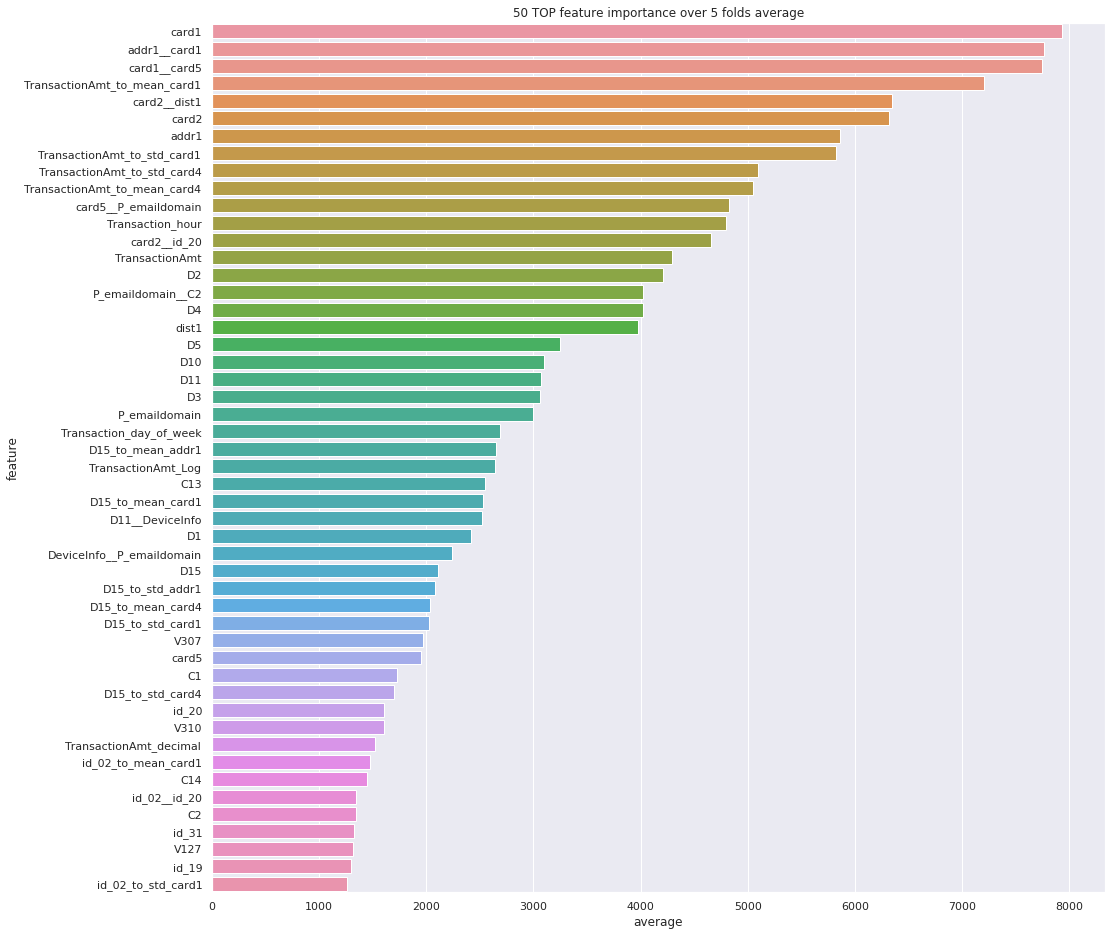

In [78]:
feature_importances['average'] = feature_importances.mean(axis = 1)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));